In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# mixed precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-07-24 06:23:19.846766: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 06:23:19.883533: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [1]:
import os
import cv2
import numpy as np
import albumentations as at
import pandas as pd
import matplotlib.pyplot as plt

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [103]:
# 데이터셋의 루트 디렉토리
dataset_directories = [
    'eardrumDs_edit',
    'fig_eardrum'
]

aug_output_directory = 'Aug_image'  # 증강된 이미지의 저장 경로

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
label_map = {
    'Normal': 0,
    'Aom': 1,
    'Chornic': 2,
    'PseduoMembran': 3,
    'tympanoskleros': 4,
    'Aom_f': 11,
    'Chornic_f': 22,
    'Normal_f': 100
}

# 증강 횟수 설정
augmentation_multipliers = {
    'Normal': 2,
    'Aom': 3,
    'Chornic': 5,
    'PseduoMembran': 5,
    'tympanoskleros': 5,
    'Aom_f': 5,
    'Chornic_f': 5,
    'Normal_f': 2
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# augmentation 함수
def apply_augmentation(image, multiplier, aug):
    augmented_images = []
    for _ in range(multiplier):
        aug_image = aug(image=image)['image']
        # 원형 마스크 생성 및 적용
        mask = np.zeros_like(aug_image)
        h, w, _ = aug_image.shape
        cv2.circle(mask, (w // 2, h // 2), min(h, w) // 2, (255, 255, 255), -1)
        aug_image = np.where(mask == 255, aug_image, 0)
        augmented_images.append(aug_image)
    return augmented_images

# 여러개 적용하는 augmentation 함수
aug_multi = at.Compose([
    at.HorizontalFlip(p=0.5),
    at.VerticalFlip(p=0.5),
    at.Rotate(limit=100, p=1, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),
    at.ShiftScaleRotate(shift_limit=0, scale_limit=(0.3, 0.7), rotate_limit=0, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),
    at.OneOf([
        at.RandomBrightnessContrast(brightness_limit=(0.1, 0.2), contrast_limit=(0.3, 0.4), p=1),
        at.RandomBrightnessContrast(brightness_limit=(0.1, 0.4), contrast_limit=0, p=1),
        at.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(0.3, 0.5), p=1),
        at.CLAHE(p=1)
    ], p=0.5)
])

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for dataset_directory in dataset_directories:
    for label_folder in os.listdir(dataset_directory):
        if label_folder == '.DS_Store':
            continue
        
        folder_path = os.path.join(dataset_directory, label_folder)
        aug_output_folder_path = os.path.join(aug_output_directory, label_folder)
        os.makedirs(aug_output_folder_path, exist_ok=True)
        
        if os.path.isdir(folder_path):
            for image_filename in os.listdir(folder_path):
                full_path = os.path.join(folder_path, image_filename)
                if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
                    # 이미지 읽기
                    img = cv2.imread(full_path)
                    if img is None:
                        print(f"Failed to read image: {full_path}")
                        continue
                    
                    # 이미지 경로 및 라벨 추가
                    image_paths.append(full_path)
                    image_labels.append(label_map.get(label_folder, -1))  # 라벨이 없는 경우 -1 추가
                    
                    # 이미지 증강 및 저장
                    multiplier = augmentation_multipliers.get(label_folder, 0)
                    if multiplier > 0:
                        augmented_images = apply_augmentation(img, multiplier, aug_multi)
                        for idx, aug_img in enumerate(augmented_images):
                            aug_filename = os.path.splitext(image_filename)[0] + f'_aug_{idx}.png'
                            aug_full_path = os.path.join(aug_output_folder_path, aug_filename)
                            cv2.imwrite(aug_full_path, aug_img)

Failed to read image: eardrumDs_edit/Normal/.DS_Store
Failed to read image: eardrumDs_edit/PseduoMembran/.DS_Store
Failed to read image: eardrumDs_edit/Chornic/.DS_Store
Failed to read image: eardrumDs_edit/tympanoskleros/.DS_Store


In [104]:
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)
label_2_count = image_labels.count(2)
label_3_count = image_labels.count(3)
label_4_count = image_labels.count(4)
label_11_count = image_labels.count(11)
label_22_count = image_labels.count(22)
label_100_count = image_labels.count(100)

print('Normal:', label_0_count)
print('Aom:', label_1_count)
print('Chornic:', label_2_count)
print('PseduoMembran:', label_3_count)
print('tympanoskleros:', label_4_count)
print('Aom_f:', label_11_count)
print('Chornic_f:', label_22_count)
print('Normal_f:', label_100_count)

Normal: 393
Aom: 119
Chornic: 59
PseduoMembran: 6
tympanoskleros: 26
Aom_f: 47
Chornic_f: 14
Normal_f: 103


In [105]:
def count_images_in_subdirectories(directory):
    subdir_image_count = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_count = len([file for file in os.listdir(subdir_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
            subdir_image_count[subdir] = image_count
    return subdir_image_count

aug_image_directory = 'Aug_image'
subdir_image_count = count_images_in_subdirectories(aug_image_directory)

subdir_image_count

{'Normal': 786,
 'PseduoMembran': 30,
 'Chornic_f': 70,
 'Chornic': 295,
 '.ipynb_checkpoints': 0,
 'Aom_f': 235,
 'tympanoskleros': 130,
 'Aom': 357,
 'Normal_f': 206}

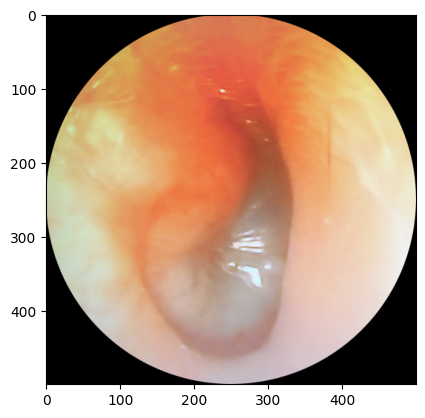

In [17]:
# 이미지 로드 (여기서는 예제 이미지 경로를 사용)
image = cv2.imread('eardrumDs_edit/Aom/aom_119.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [18]:
# 이미지 배열을 입력받아 5개 출력하는 함수
def show_images(images, labels):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 8))
    for i in range(5):
        axs[i].imshow(images[i])
        axs[i].set_title(labels[i])

# 원본 이미지를 입력받아 4개의 augmentation 적용하여 시각화
def aug_apply(image, label, aug):
    image_list = [image]
    label_list = ['origin']

    for i in range(4):
        aug_image = aug(image=image)['image']
        
        # 원형 마스크 생성 및 적용
        mask = np.zeros_like(aug_image)
        h, w, _ = aug_image.shape
        cv2.circle(mask, (w//2, h//2), min(h, w)//2, (255, 255, 255), -1)
        aug_image = np.where(mask == 255, aug_image, 0)

        image_list.append(aug_image)
        label_list.append(label)

    show_images(image_list, label_list)

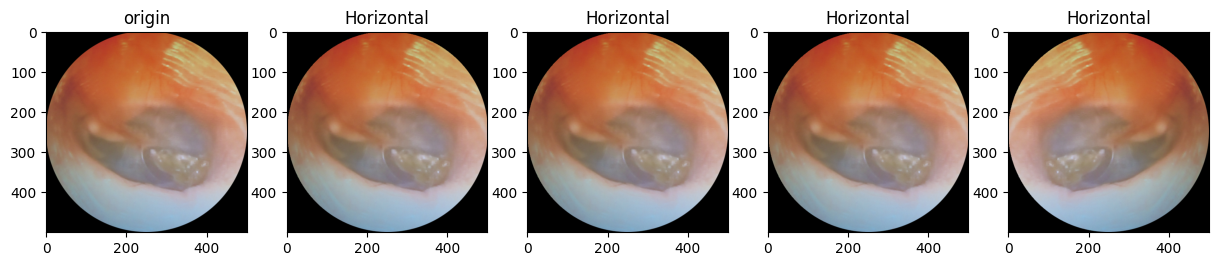

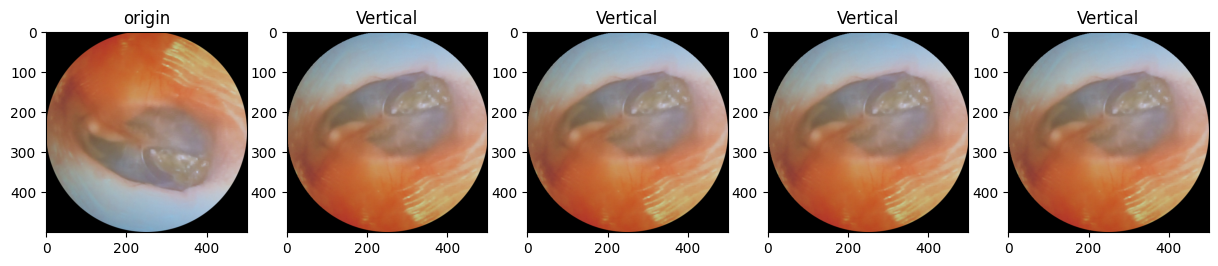

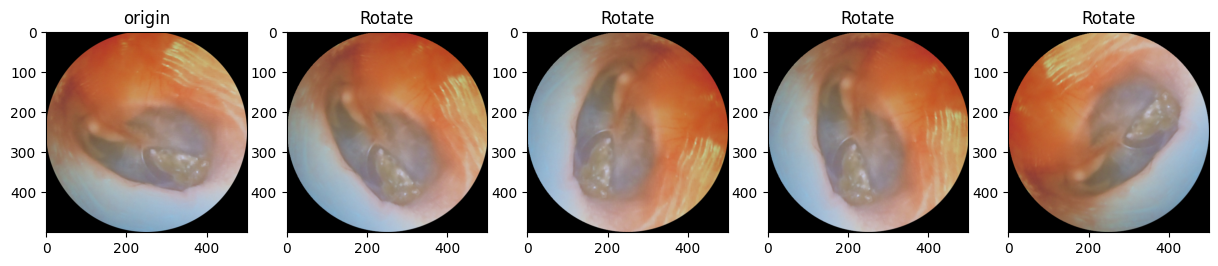

In [28]:
# 좌우 반전
aug_horizontal = at.HorizontalFlip(p=0.5)
# 상하 반전
aug_vertical = at.VerticalFlip(p=0.5)
# -100 ~ 100도 사이로 돌림, 남은 공간은 주변 환경으로 채움 (cv2.BORDER_CONSTAN, cv2.BORDER_REFLECT, cv2.BORDER_REFLECT_101, cv2.BORDER_WRAP)
aug_rotate = at.Rotate(limit=100, p=1, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0))

aug_apply(image=image, label='Horizontal', aug=aug_horizontal)
aug_apply(image=image, label='Vertical', aug=aug_vertical)
aug_apply(image=image, label='Rotate', aug=aug_rotate)

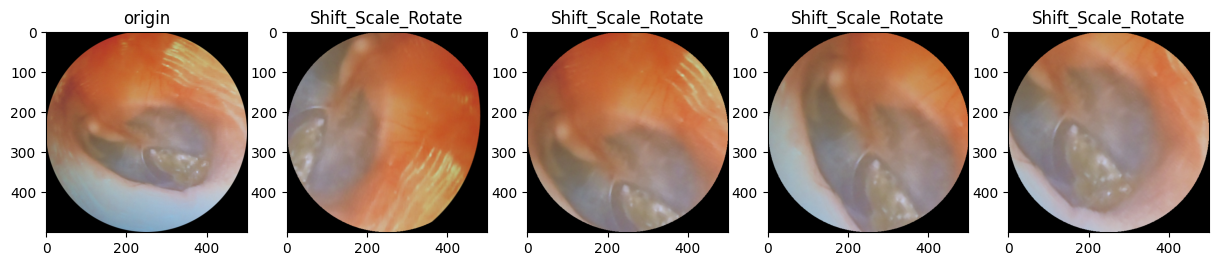

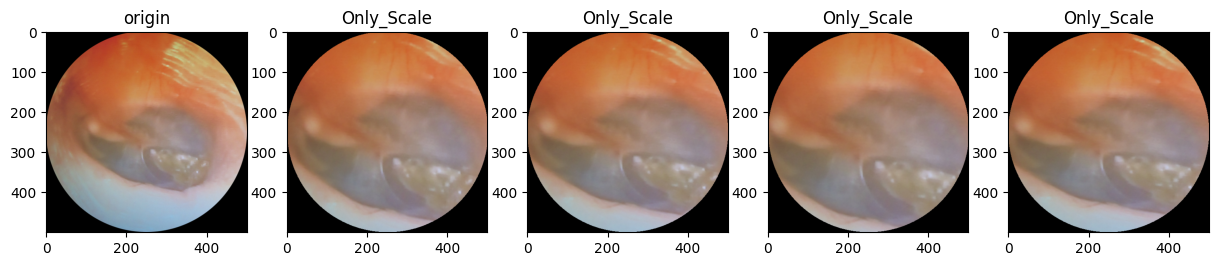

In [37]:
aug_shift_scale_rotate = at.ShiftScaleRotate(shift_limit=0.2, scale_limit=(0.3, 0.7), rotate_limit=100, p=1, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0))
aug_only_scale = at.ShiftScaleRotate(shift_limit=0, scale_limit=(0.3, 0.7), rotate_limit=0, p=1, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0))

aug_apply(image=image, label='Shift_Scale_Rotate', aug=aug_shift_scale_rotate)
aug_apply(image=image, label='Only_Scale', aug=aug_only_scale)

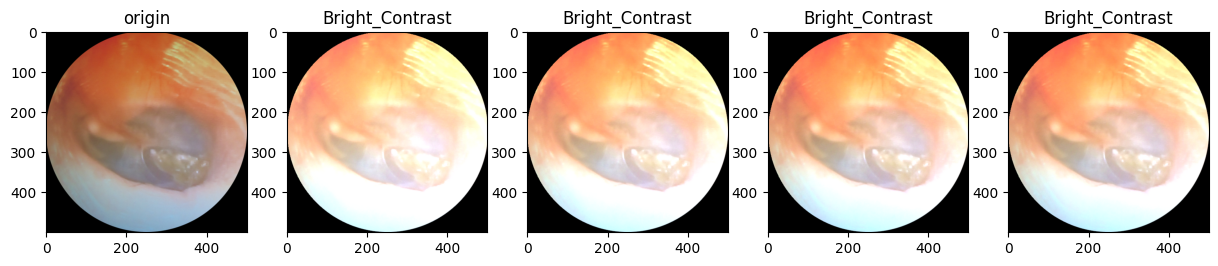

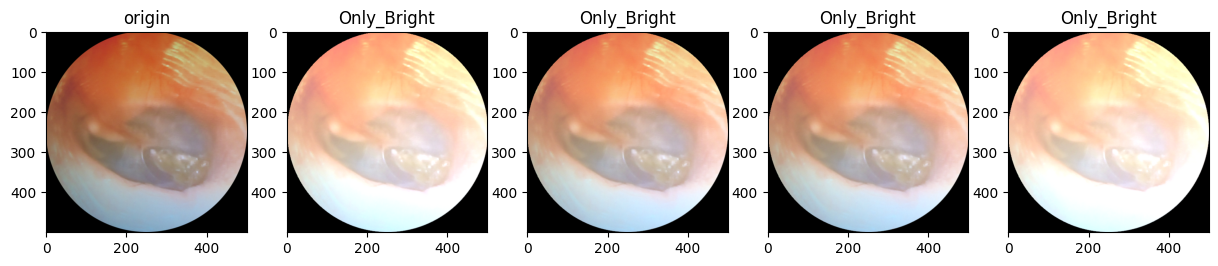

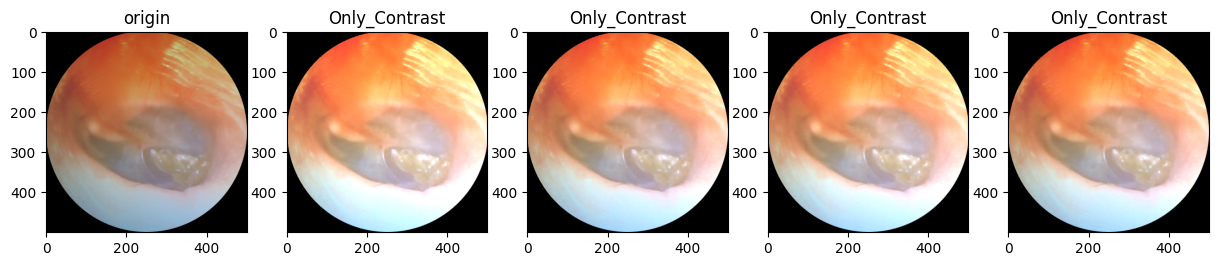

In [72]:
# 밝기와 대비 변경 (대비를 올리면 어두운색은 더 어둡게, 밝은색은 더 밝게)
aug_bright_contrast = at.RandomBrightnessContrast(brightness_limit=(0.1, 0.2), contrast_limit=(0.3, 0.4), p=1)
# 밝기만 변경
aug_bright = at.RandomBrightnessContrast(brightness_limit=(0.1, 0.4), contrast_limit=0, p=1)
# 대비만 변경
aug_contrast = at.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(0.3, 0.5), p=1)

aug_apply(image=image, label='Bright_Contrast', aug=aug_bright_contrast)
aug_apply(image=image, label='Only_Bright', aug=aug_bright)
aug_apply(image=image, label='Only_Contrast', aug=aug_contrast)

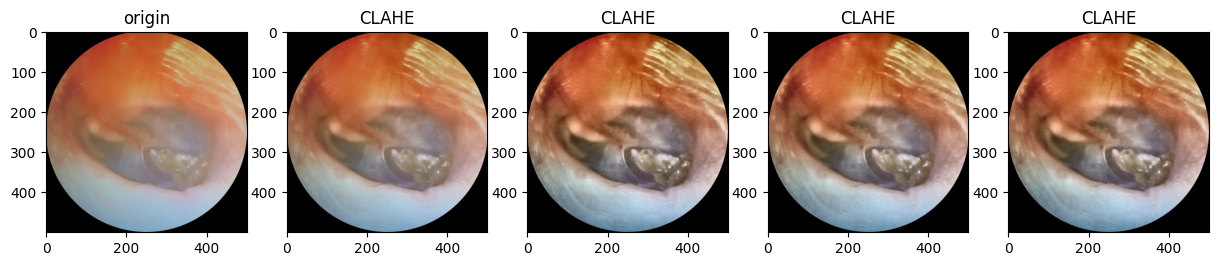

In [73]:
# 히스토그램 균일화 기법인 CLAHE를 이용하여 보다 선명한 이미지 재생
aug_clahe = at.CLAHE(p=1)

aug_apply(image=image, label='CLAHE', aug=aug_clahe)

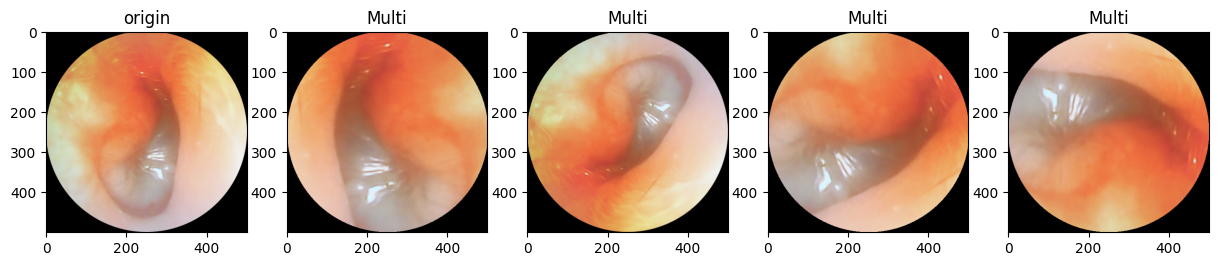

In [19]:
#여러개 적용
aug_multi = at.Compose([
    at.HorizontalFlip(p=0.5),
    at.VerticalFlip(p=0.5),
    at.Rotate(limit=100, p=1, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),
    at.ShiftScaleRotate(shift_limit=0, scale_limit=(0.3, 0.7), rotate_limit=0, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),
    at.OneOf([
        at.RandomBrightnessContrast(brightness_limit=(0.1, 0.2), contrast_limit=(0.3, 0.4), p=1),
        at.RandomBrightnessContrast(brightness_limit=(0.1, 0.4), contrast_limit=0, p=1),
        at.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(0.3, 0.5), p=1),
        at.CLAHE(p=1)
    ], p=0.5)
])

aug_apply(image=image, label='Multi', aug=aug_multi)

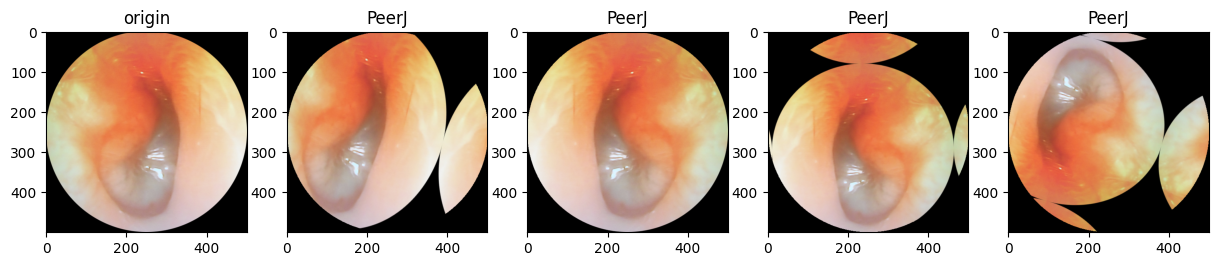

In [12]:
data_gen_args = at.Compose([
    at.HorizontalFlip(p=0.5),
    at.VerticalFlip(p=0.5),
    at.RandomBrightnessContrast(p=0.3),
    at.ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.2, rotate_limit = 20, p=0.5)
])

aug_apply(image=image, label='PeerJ', aug=data_gen_args)

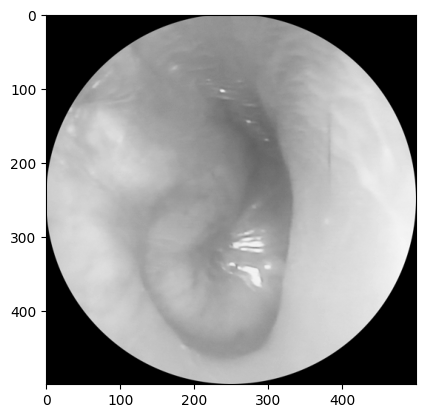

In [3]:
image = cv2.imread('eardrumDs_edit/Aom/aom_119.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap='gray')
plt.show()

In [4]:
import os
import cv2

# 데이터셋의 루트 디렉토리
dataset_directory = 'eardrumDs'
output_directory = 'eardrumDs_gray'  # 그레이스케일 이미지의 저장 경로

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder == '.DS_Store':
        continue
    
    folder_path = os.path.join(dataset_directory, label_folder)
    aug_output_folder_path = os.path.join(output_directory, label_folder)
    os.makedirs(aug_output_folder_path, exist_ok=True)
    
    if os.path.isdir(folder_path):
        for image_filename in os.listdir(folder_path):
            full_path = os.path.join(folder_path, image_filename)
            output_path = os.path.join(aug_output_folder_path, image_filename)
            if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
                # 이미지 읽기
                img = cv2.imread(full_path)
                if img is None:
                    print(f"Failed to read image: {full_path}")
                    continue
                
                # 이미지를 그레이스케일로 변환
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # 변환된 이미지 저장
                cv2.imwrite(output_path, gray_img)
                print(f"Saved grayscale image to: {output_path}")

Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_33.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_15.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_6.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_5.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_13.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_20.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_14.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_41.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_37.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_10.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_2.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_27.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/otitexterna_38.tiff
Saved grayscale image to: eardrumDs_gray/OtitExterna/o